# Lab Making predictions with logistic regression
_Week3 - Day4_

## Aim
In order to optimize our inventory, we would like to know which films will be rented. We are asked to create a model to predict it. So we use the information we have from May 2005 to create the model

## Instructions
- Create a query or queries to extract the information you think may be relevant for building the prediction model. It should include some film features and some rental features (X).
- Create a query to get the list of all unique film titles and a boolean indicating if it was rented (rental_date) in May 2005. (Create new column called - 'rented_in_may'). This will be our TARGET (y) variable.
- Read the data into a Pandas dataframe. At this point you should have 1000 rows. Number of columns depends on the number of features you chose.
- Analyze extracted features (X) and transform them. You may need to encode some categorical variables, or scale numerical variables.
- Create a logistic regression model to predict 'rented_in_may' from the cleaned data.
- Evaluate the results.

In [2]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

In [3]:
# connect database and define engine
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)

## Features selection
- Film: title, length, category(from table category), rental rate
- Rental: rental_date, return_date

(In a more advanced model might be interesting to add the distance between customer address and the store or the language - but the movies seem to be all in one)

In [4]:
film = pd.read_sql_table('film', engine)
display(film.columns)
display(film.head())

Index(['film_id', 'title', 'description', 'release_year', 'language_id',
       'original_language_id', 'rental_duration', 'rental_rate', 'length',
       'replacement_cost', 'rating', 'special_features', 'last_update'],
      dtype='object')

,film_id,title,description,release_year,language_id,original_language_id,rental_duration,rental_rate,length,replacement_cost,rating,special_features,last_update
0,1,ACADEMY DINOSAUR,A Epic Drama of a Feminist And a Mad Scientist...,2006,1,None,6,0.99,86,20.99,PG,"{Deleted Scenes, Behind the Scenes}",2006-02-15 05:03:42
1,2,ACE GOLDFINGER,A Astounding Epistle of a Database Administrat...,2006,1,None,3,4.99,48,12.99,G,"{Trailers, Deleted Scenes}",2006-02-15 05:03:42
2,3,ADAPTATION HOLES,A Astounding Reflection of a Lumberjack And a ...,2006,1,None,7,2.99,50,18.99,NC-17,"{Trailers, Deleted Scenes}",2006-02-15 05:03:42
3,4,AFFAIR PREJUDICE,A Fanciful Documentary of a Frisbee And a Lumb...,2006,1,None,5,2.99,117,26.99,G,"{Behind the Scenes, Commentaries}",2006-02-15 05:03:42
4,5,AFRICAN EGG,A Fast-Paced Documentary of a Pastry Chef And ...,2006,1,None,6,2.99,130,22.99,G,{Deleted Scenes},2006-02-15 05:03:42


In [5]:
# These are potentially interesting categories to include in the model.
# However, after checking them, it turns out that they only have one value.
# So they are not useful/relevant for the prediction
display(film['release_year'].unique())
display(film['language_id'].unique())
display(film['original_language_id'].unique())

array([2006], dtype=int64)

array([1], dtype=int64)

array([None], dtype=object)

In [6]:
rental = pd.read_sql_table('rental', engine)
rental.head()

c:\Users\marta\anaconda3\lib\site-packages\pandas\io\sql.py:1779: SAWarning: Did not recognize type 'geometry' of column 'location'
  tbl = Table(


,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update
0,1,2005-05-24 22:53:30,367,130,2005-05-26 22:04:30,1,2006-02-15 21:30:53
1,2,2005-05-24 22:54:33,1525,459,2005-05-28 19:40:33,1,2006-02-15 21:30:53
2,3,2005-05-24 23:03:39,1711,408,2005-06-01 22:12:39,1,2006-02-15 21:30:53
3,4,2005-05-24 23:04:41,2452,333,2005-06-03 01:43:41,2,2006-02-15 21:30:53
4,5,2005-05-24 23:05:21,2079,222,2005-06-02 04:33:21,1,2006-02-15 21:30:53


Data retrieve

In [7]:
query_data = """
SELECT f.title, f.rental_rate, f.length, f.rating, r.rental_date, c.name as category
FROM film f
JOIN inventory i ON f.film_id = i.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
JOIN film_category fc ON f.film_id = fc.film_id
JOIN category c ON fc.category_id = c.category_id

"""

In [8]:
data_film = pd.read_sql_query(query_data, engine)
display(data_film.shape)
display(data_film.head())

(16045, 6)

,title,rental_rate,length,rating,rental_date,category
0,AMADEUS HOLY,0.99,113,PG,2005-08-02 01:16:59,Action
1,AMADEUS HOLY,0.99,113,PG,2005-08-18 04:26:54,Action
2,AMADEUS HOLY,0.99,113,PG,2005-06-20 20:35:28,Action
3,AMADEUS HOLY,0.99,113,PG,2005-07-09 05:01:58,Action
4,AMADEUS HOLY,0.99,113,PG,2005-07-30 08:02:39,Action


In [9]:
min(data_film['rental_date'])
# We can see that there are no rentals before May 2005

Timestamp('2005-05-24 22:53:30')

In [10]:
data_film['rental_date'].agg(['min', 'max'])

min   2005-05-24 22:53:30
max   2023-04-10 17:57:40
Name: rental_date, dtype: datetime64[ns]

## Movie rental in May 2005
-  Try with distinct on titles

In [11]:
query_may = '''
SELECT f.title,
       MIN(r.rental_date) AS rental_date,
       c.name AS category_name,
       CASE WHEN YEAR(MIN(r.rental_date)) = 2005 AND MONTH(MIN(r.rental_date)) = 5
            THEN True
            ELSE False
       END AS rented_in_may,
       f.length,
       f.rental_rate,
       f.rating
FROM film f
JOIN inventory i ON f.film_id = i.film_id
JOIN rental r ON i.inventory_id = r.inventory_id
JOIN film_category fc ON f.film_id = fc.film_id
JOIN category c ON fc.category_id = c.category_id
GROUP BY f.title, c.name, f.length, f.rental_rate, f.rating;
'''

In [12]:
data_may = pd.read_sql_query(query_may, engine)
display(data_may.shape)
display(data_may.head(20))

(958, 7)

,title,rental_date,category_name,rented_in_may,length,rental_rate,rating
0,AMADEUS HOLY,2005-05-28 12:08:37,Action,1,113,0.99,PG
1,AMERICAN CIRCUS,2005-05-25 21:58:58,Action,1,129,4.99,R
2,ANTITRUST TOMATOES,2005-05-31 16:48:43,Action,1,168,2.99,NC-17
3,BAREFOOT MANCHURIAN,2005-05-26 20:57:00,Action,1,129,2.99,G
4,BERETS AGENT,2005-05-29 23:37:00,Action,1,77,2.99,PG-13
5,BRIDE INTRIGUE,2005-05-29 17:28:12,Action,1,56,0.99,G
6,BULL SHAWSHANK,2005-06-17 09:17:39,Action,0,125,0.99,NC-17
7,CADDYSHACK JEDI,2005-05-29 02:18:54,Action,1,52,0.99,NC-17
8,CAMPUS REMEMBER,2005-05-31 09:55:04,Action,1,167,2.99,R
9,CASUALTIES ENCINO,2005-05-30 02:45:16,Action,1,179,4.99,G


In [13]:
# double-check that indeed the titles are unique -> should be the same number are rows
uniqueValues = data_may['title'].nunique()
print(uniqueValues)

958


## Data exploration

In [14]:
# check data types
data_may.dtypes

title                    object
rental_date      datetime64[ns]
category_name            object
rented_in_may             int64
length                    int64
rental_rate             float64
rating                   object
dtype: object

In [15]:
# check if there are missing values
data_may.isna().sum()

title            0
rental_date      0
category_name    0
rented_in_may    0
length           0
rental_rate      0
rating           0
dtype: int64

### Categorical variables

In [16]:
data_may['category_name'].value_counts(dropna=False)
# no class imbalance

Sports         73
Family         67
Foreign        67
Animation      64
Documentary    63
Action         61
Drama          61
New            60
Sci-Fi         59
Children       58
Games          58
Comedy         56
Classics       54
Horror         53
Travel         53
Music          51
Name: category_name, dtype: int64

In [17]:
data_may['rating'].value_counts(dropna=False)
# no big class imbalance

PG-13    213
NC-17    202
R        189
PG       183
G        171
Name: rating, dtype: int64

### Numerical variables

In [18]:
import numpy as np
import pandas as pd

In [19]:
data_may_num = data_may.select_dtypes(include = np.number)

In [20]:
data_may_num.describe().T

,count,mean,std,min,25%,50%,75%,max
rented_in_may,958.0,0.716075,0.451136,0.00,0.00,1.00,1.00,1.00
length,958.0,115.490605,40.471844,46.00,80.25,114.00,150.00,185.00
rental_rate,958.0,2.977474,1.643152,0.99,0.99,2.99,4.99,4.99


In [21]:
data_may_num['rented_in_may'].value_counts(dropna=False) # class imbalance -> we will deal with this in future labs

1    686
0    272
Name: rented_in_may, dtype: int64

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

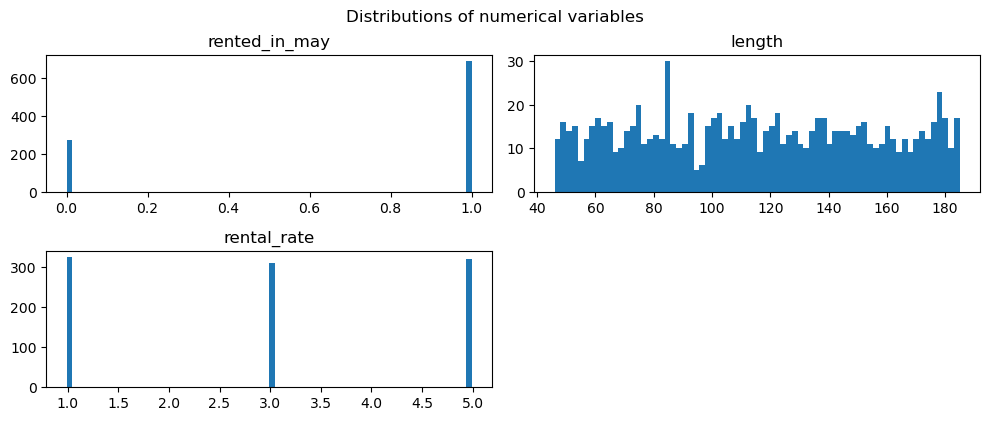

In [23]:
def draw_histograms(df, variables, n_rows, n_cols):
    fig=plt.figure()
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=70,ax=ax,figsize=(10,10))
        ax.set_title(var_name)
        ax.grid(False)
    fig.suptitle('Distributions of numerical variables')
    fig.tight_layout()  
    plt.show()

draw_histograms(data_may_num, data_may_num.columns, 5, 2) 

In [24]:
display(data_may_num['rental_rate'].unique())
# only 3 values -> categorical

array([0.99, 4.99, 2.99])

In [25]:
data_may['rental_rate'] = data_may['rental_rate'].astype('object')
# change it in the original table so it's already done before the split
# numerical table only created for data exploration
data_may['rental_rate'].value_counts()
# no class imbalance

0.99    326
4.99    320
2.99    312
Name: rental_rate, dtype: int64

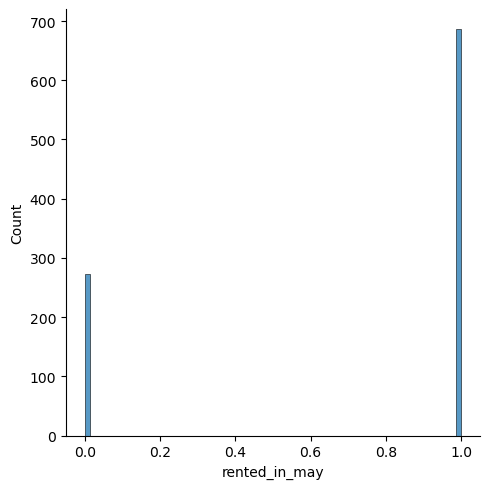

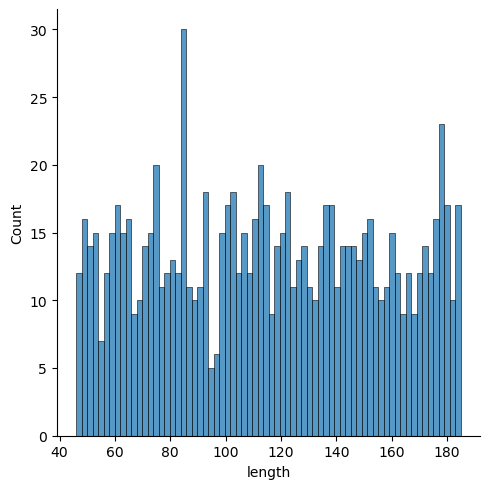

In [26]:
def plot_distributions(df):
    numerical_columns = df.select_dtypes(np.number)
    for col in numerical_columns:
        sns.displot(df [col], bins=70)
        plt.show()

plot_distributions(data_may)        

In [29]:
def plot_distributions(df):
    num_cols = df.select_dtypes(np.number).columns.tolist()
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # Remove 'rented_in_may' variable from the list of numerical columns
    num_cols.remove('rented_in_may')
    # Remove 'title' variable from the list of categorical columns
    cat_cols.remove('title')
    
    for col in num_cols:
        sns.histplot(data=df, x=col, kde=True, bins=70)
        plt.show()
    
    for col in cat_cols:
        sns.countplot(data=df, y=col, orient = 'h')
        plt.show()

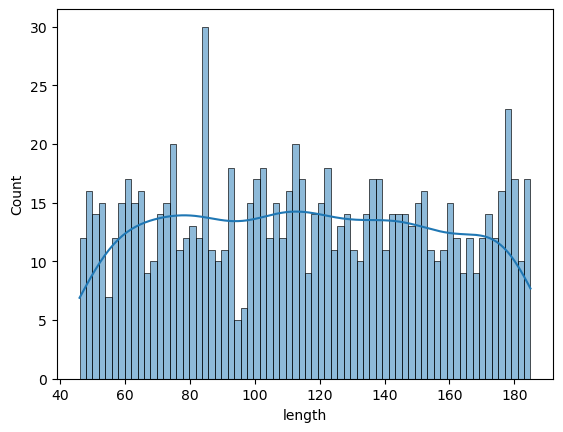

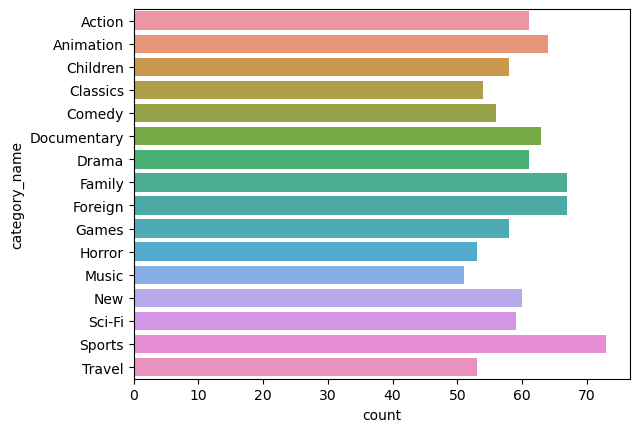

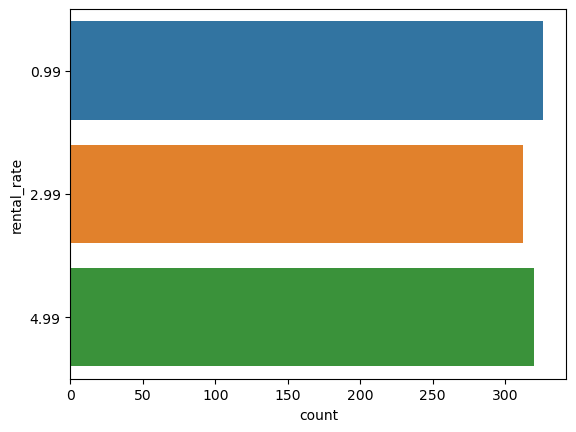

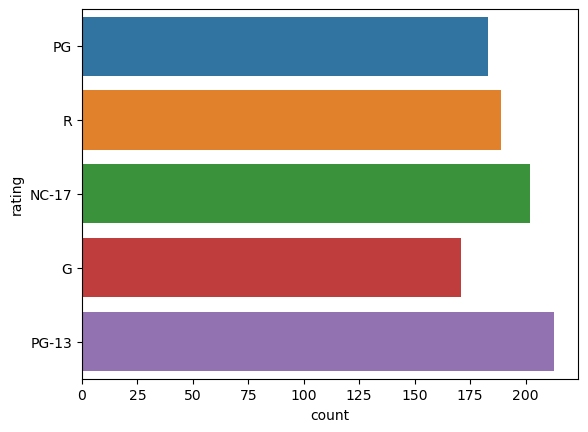

In [30]:
plot_distributions(data_may)

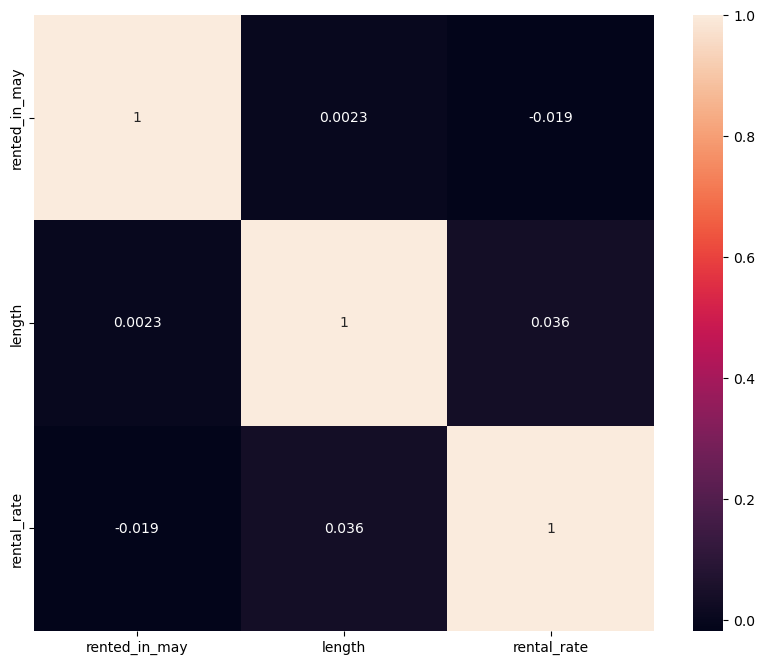

In [31]:
# Multicollinearity
corr_matrix=data_may_num.corr() # default: Pearson
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

# Here 'rental_rate' is still included to explore the relationship with length and with the dependent variable. As we can see, there's not much correlation

## Building the model

### X-y and train-test split

In [32]:
# Need to X-y-split AND train-test-split BEFORE I apply transformations, 
# then train transformation on training set only
y = data_may['rented_in_may']
X = data_may.drop('rented_in_may', axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

In [33]:
X_train.dtypes

title                    object
rental_date      datetime64[ns]
category_name            object
length                    int64
rental_rate              object
rating                   object
dtype: object

### Data transformations

In [34]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

X_train_num = X_train.select_dtypes(include = np.number)
X_test_num  = X_test.select_dtypes(include = np.number)

# Scaling data
transformer = MinMaxScaler().fit(X_train_num) # need to keep transformer

X_train_normalized = transformer.transform(X_train_num)
X_test_normalized  = transformer.transform(X_test_num)

X_train_norm_df = pd.DataFrame(X_train_normalized, columns=X_train_num.columns)
X_test_norm_df  = pd.DataFrame(X_test_normalized, columns=X_test_num.columns)

In [35]:
X_train_norm_df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,766.0,0.506086,0.289162,0.0,0.266187,0.503597,0.746403,1.0


In [ ]:
# I'm going to drop the column titles because ALL values are different - so there's no patter that could help explaining the rental 
# and we cannot really transform it as we will get with, for example, the OneHotEncoder as many columns as movie titles.
# plus the columns for the train and the test set will be different

In [36]:
X_train = X_train.drop(['title'], axis=1)

In [37]:
X_test = X_test.drop(['title'], axis=1)

In [38]:
X_train.head()

,rental_date,category_name,length,rental_rate,rating
70,2005-05-29 10:18:59,Animation,65,0.99,PG-13
102,2005-05-25 19:07:40,Animation,85,2.99,R
515,2005-05-31 05:21:10,Foreign,181,0.99,G
120,2005-05-28 23:27:26,Animation,142,0.99,G
133,2005-06-16 02:35:03,Children,143,0.99,PG-13


In [39]:
X_train_cat = X_train.select_dtypes('object')
X_test_cat  = X_test.select_dtypes('object')

from sklearn.preprocessing import OneHotEncoder

#categories_values = [list(data[col].unique()) for col in X_train_categorical.columns]
encoder = OneHotEncoder(drop='first')
encoder.fit(X_train_cat)

X_train_cat_np = encoder.transform(X_train_cat).toarray()
X_test_cat_np  = encoder.transform(X_test_cat).toarray()

X_train_cat_oh_df = pd.DataFrame(X_train_cat_np, columns=encoder.get_feature_names_out())
X_test_cat_oh_df  = pd.DataFrame(X_test_cat_np,  columns=encoder.get_feature_names_out())

In [40]:
X_train_cat_oh_df.head()

,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,category_name_Documentary,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,category_name_Horror,...,category_name_New,category_name_Sci-Fi,category_name_Sports,category_name_Travel,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Plot distributions

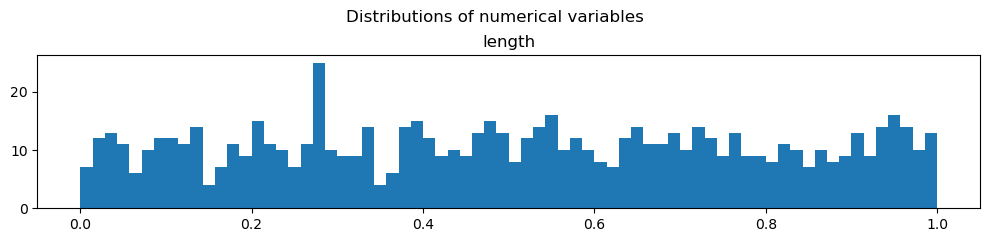

In [43]:
draw_histograms(X_train_norm_df, X_train_norm_df.columns, 5, 1) 

## Logistic regression

In [44]:
X_train_transformed = pd.concat([X_train_norm_df, X_train_cat_oh_df], axis=1)
X_test_transformed = pd.concat([X_test_norm_df, X_test_cat_oh_df], axis=1)

In [45]:
X_train_transformed.head()

,length,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,category_name_Documentary,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,...,category_name_New,category_name_Sci-Fi,category_name_Sports,category_name_Travel,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.136691,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.280576,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,0.971223,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.690647,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.697842,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [46]:
from sklearn.linear_model import LogisticRegression

logreg1 = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')

logreg1.fit(X_train_transformed, y_train)

LogisticRegression(multi_class='multinomial', random_state=0)

### Predictions

In [47]:
y_test_pred1 = logreg1.predict(X_test_transformed)
print(y_test_pred1)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]


In [48]:
coef_table = pd.DataFrame(list(logreg1.coef_),columns=X_test_transformed.columns) # Coefficients
coef_table

,length,category_name_Animation,category_name_Children,category_name_Classics,category_name_Comedy,category_name_Documentary,category_name_Drama,category_name_Family,category_name_Foreign,category_name_Games,...,category_name_New,category_name_Sci-Fi,category_name_Sports,category_name_Travel,rental_rate_2.99,rental_rate_4.99,rating_NC-17,rating_PG,rating_PG-13,rating_R
0,0.059387,0.01794,-0.039807,-0.059431,-0.199808,0.005037,0.146941,0.010691,-0.130426,-0.219209,...,-0.359678,0.026944,-0.251677,-0.288705,-0.18978,-0.009978,0.02078,0.052795,0.037799,-0.046254


### Evaluating the model

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

print("Accuracy (test set): {:.2f}".format(accuracy_score(y_test,y_test_pred1)))
print("Precision (test set): {:.2f}".format(precision_score(y_test,y_test_pred1)))
print("Recall (test set): {:.2f}".format(recall_score(y_test,y_test_pred1)))
print("F1 (test set): {:.2f}".format(f1_score(y_test,y_test_pred1)))
print("Kappa (test set): {:.2f}".format(cohen_kappa_score(y_test,y_test_pred1)))

Accuracy (test set): 0.66
Precision (test set): 0.66
Recall (test set): 1.00
F1 (test set): 0.79
Kappa (test set): 0.00


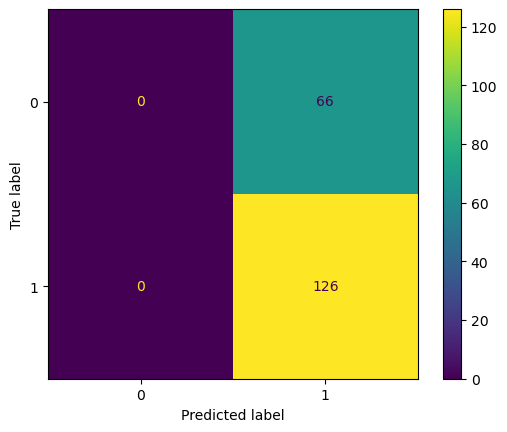

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_test1 = confusion_matrix(y_test,y_test_pred1) # real and predicted values
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test1, display_labels=logreg1.classes_) # labels of the classes
disp.plot()
plt.show()

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        66
           1       0.66      1.00      0.79       126

    accuracy                           0.66       192
   macro avg       0.33      0.50      0.40       192
weighted avg       0.43      0.66      0.52       192



c:\Users\marta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marta\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Conclusions
- The model only predicted that ALL movies will be rented (recall = 1).
- This is probably due to the high class imbalance between the movies that are rented in may and those that are not ('0'. Very few movies)
- Also, it would be worth to apply other scaler/transformetion to the numerical variable,

Important to check ALL error metrics, not only the accuracy (check 3.09 notebook - week3, day5)

_The code below is just for testing_

In [74]:
logreg2 = LogisticRegression(random_state=0, solver='saga', multi_class='multinomial')

logreg2.fit(X_train_transformed, y_train)

LogisticRegression(multi_class='multinomial', random_state=0, solver='saga')

In [75]:
y_test_pred2 = logreg2.predict(X_test_transformed)
print(y_test_pred2)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
